# Import Packages

In [5]:
## install required packages

#pip install torchmetrics torchmetrics[image] torch-fidelity

In [7]:
import os 
import math
import numpy as np

# pytorch imports

## dataset and data loader dependencies
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
# image processing dependencies
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision.utils import save_image
from torchvision import utils as vutils
# model dependencies
import torch
import torch.nn as nn
import torchvision
from torchvision.utils import make_grid
from torch.utils.tensorboard import SummaryWriter # logger
import torch.nn.functional as F
import torchvision.transforms as transforms
import cv2


In [ ]:
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore

# Configuration Options


In [8]:
device           = torch.device("cuda:0")  
test_name         = "stret_to_aerial_v5" 

In [9]:
    
    # dataset configurations.
    result_dataset_dir = f"results_{test_name}" 

    real_train_data = '/common/home/tp577/Downloads/Training/task3_sa/street_to_arial/train_images'

    valid_data = '/common/home/tp577/Downloads/Training/task3_sa/street_to_arial/validation_images'

    IMG_HEIGHT = 256
    IMG_WIDTH = 256
                  
    batch_size            = 24   # Training batch size.
    image_size = 256
    n_gpus=1
    global_batch_size=n_gpus*batch_size
    
        
    # Train params.
    epochs  = 200  
    lr = 0.0002  


    # Training log.
    writer                = SummaryWriter(os.path.join(f"{result_dataset_dir}/stats",  "logs", test_name))
    
    # Additional variables and create directories
    models_dir =  os.path.join(f"{result_dataset_dir}/models", test_name)
    samples_dir = os.path.join(f"{result_dataset_dir}/samples", test_name)
    results_dir = os.path.join(f"{result_dataset_dir}/results", test_name)
    
    os.makedirs(result_dataset_dir, exist_ok=True)
    os.makedirs(samples_dir, exist_ok=True)
    os.makedirs(models_dir, exist_ok=True)
    os.makedirs(results_dir, exist_ok=True)
    os.makedirs("results",exist_ok=True)

# Data processing

In [10]:
# method to get individual images from a batch
def load_image(image):
    image = np.array(image)
    width = image.shape[1]
    half_val = width // 2

    real_image = image[:, :half_val, :] # left section
    conditonal_image = image[:, half_val:, :] # right section

    real_image = real_image.astype(np.float32) # convert to float
    conditonal_image = conditonal_image.astype(np.float32) # convert to float

    return real_image, conditonal_image # return real and conditional images


## image transforms


In [11]:
# method to crop images to 256x256
# we use a random crop instead of center crop
def random_crop(image, dim):
    height, width, _ = dim
    x, y = np.random.uniform(low=0,high=int(height-256)), np.random.uniform(low=0,high=int(width-256))  
    return image[:, int(x):int(x)+256, int(y):int(y)+256]

# random jittering and horizantal flipping for data augmentation
# this is a function that takes in an image and returns the same image with some random transformations
# cv2 is used to perform the transformations
def random_jittering_mirroring(input_image, target_image, height=256, width=256):
    #resizing to 256x256
    input_image = cv2.resize(input_image, (height, width) ,interpolation=cv2.INTER_NEAREST)
    target_image = cv2.resize(target_image, (height, width),
                               interpolation=cv2.INTER_NEAREST)
    
    #cropping (random jittering) to 256x256
    stacked_image = np.stack([input_image, target_image], axis=0)
    cropped_image = random_crop(stacked_image, dim=[IMG_HEIGHT, IMG_WIDTH, 3])
    
    input_image, target_image = cropped_image[0], cropped_image[1]
  
    if torch.rand(()) > 0.5: # 50% chance of flipping
        # random mirroring
        input_image = np.fliplr(input_image)
        target_image = np.fliplr(target_image)
    return input_image, target_image

## normalize the image pixel transformation

In [12]:
# normalize the image to be between -1 and 1
# reduces learning time and improves convergence
def normalize(inp, tar):
    input_image = (inp / 127.5) - 1
    target_image = (tar / 127.5) - 1
    return input_image, target_image

In [13]:
# Transform function
class Transformations(object):
    def __call__(self, image):
        inp, tar = load_image(image)
        inp, tar = random_jittering_mirroring(inp, tar)
        inp, tar = normalize(inp, tar)
        image_a = torch.from_numpy(inp.copy().transpose((2,0,1)))
        image_b = torch.from_numpy(tar.copy().transpose((2,0,1)))
        return image_a, image_b

# Data loaders

## train data loader

In [ ]:
# Dataset class
train_ds = ImageFolder(real_train_data, transform=transforms.Compose([Transformations()]))
# Data loader
train_dl = DataLoader(train_ds, global_batch_size)

## validation data loader

In [ ]:
# validation dataset class
valid_ds = ImageFolder(valid_data, transform=transforms.Compose([Transformations()]))
# validation data loader
valid_dl = DataLoader(valid_ds, global_batch_size)

# Model weight intialsations 

In [15]:
# custom weights initialization called on generator and discriminator

def init_weights(net, init_type='normal', scaling=0.02):
    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv')) != -1:
            torch.nn.init.normal_(m.weight.data, 0.0, scaling)
        elif classname.find('BatchNorm2d') != -1:  
            torch.nn.init.normal_(m.weight.data, 1.0, scaling)
            torch.nn.init.constant_(m.bias.data, 0.0)
    net.apply(init_func)  # apply the initialization function <init_func>

# Downsample and Upsample Reusable code blocks


In [16]:
# SkipConnection layer
class UnetSkipConnectionBlock(nn.Module):
    def __init__(self, outer_nc, inner_nc, input_nc=None,
                 submodule=None, outermost=False, innermost=False, norm_layer=nn.BatchNorm2d, use_dropout=False):
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost
        if input_nc is None:
            input_nc = outer_nc
        downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = norm_layer(inner_nc)
        uprelu = nn.ReLU(True)
        upnorm = norm_layer(outer_nc)

        if outermost:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(inner_nc, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:   # skip connections
            return torch.cat([x, self.model(x)], 1)

# Generator model Architecture
The first part network contracts and then expands again, i.e. first we have encoder block and then decoder block.T
```
Encoder:  C64-C128-C256-C512-C512-C512-C512-C512

Decoder:  CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128
```

In [17]:

class UnetGenerator(nn.Module):
    
    def __init__(self, input_nc, output_nc, nf=64, norm_layer=nn.BatchNorm2d, use_dropout=False):
        super(UnetGenerator, self).__init__()
       
        unet_block = UnetSkipConnectionBlock(nf * 8, nf * 8, input_nc=None, submodule=None, norm_layer=norm_layer, innermost=True) 

        unet_block = UnetSkipConnectionBlock(nf * 8, nf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)
        unet_block = UnetSkipConnectionBlock(nf * 8, nf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)
        unet_block = UnetSkipConnectionBlock(nf * 8, nf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)

        unet_block = UnetSkipConnectionBlock(nf * 4, nf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(nf * 2, nf * 4, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(nf, nf * 2, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        
        self.model = UnetSkipConnectionBlock(output_nc, nf, input_nc=input_nc, submodule=unet_block, outermost=True, norm_layer=norm_layer)  

    def forward(self, input):
        return self.model(input)

# Create the Generator 



In [18]:
norm_layer=nn.BatchNorm2d

generator = UnetGenerator(3, 3, 64, norm_layer=norm_layer, use_dropout=False).cuda().float() # define the generator

# intialize the weights
init_weights(generator, 'normal', scaling=0.02)

generator = torch.nn.DataParallel(generator,device_ids=[0])  # multi-GPUs

# Discriminator Archictecture

PatchGAN is the discriminator used for Pix2Pix. Its architecture is different from a typical image classification ConvNet because of the output layer size. In convnets output layer size is equal to the number of classes while in PatchGAN output layer size is a 2D matrix.

In [19]:
class Discriminator(nn.Module):
    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d):
        super(Discriminator, self).__init__()
        kw = 4
        padw = 1
        sequence = [nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw), nn.LeakyReLU(0.2, True)]
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):  
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw, bias=False),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw, bias=False),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw), nn.Sigmoid()]  
        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        return self.model(input)

# Discriminator intialisation

In [20]:

discriminator = Discriminator( 6, 64, norm_layer=norm_layer).cuda().float() # define the discriminator
# intialize the weights
init_weights(discriminator, 'normal', scaling=0.02)
# parallelize the discriminator 
discriminator = torch.nn.DataParallel(discriminator,device_ids=[0])

# loss functions


Loss function used in Pix2Pix are `Adversarial loss` and  `Reconstruction loss`. 
- Adversarial loss is used to penalize the generator to predict more realistic images.
- Reconstruction Loss helps network to produce the realistic image near the conditional image.

In [21]:
adversarial_loss = nn.BCELoss()  # resposible for 
l1_loss = nn.L1Loss() # responsible for the pixel loss

## loss function


In [22]:
def generator_loss(generated_image, target_img, G, real_target):
    gen_loss = adversarial_loss(G, real_target)
    l1_l = l1_loss(generated_image, target_img)
    gen_total_loss = gen_loss + (100 * l1_l)
    #print(gen_loss)
    return gen_total_loss

##  Discriminator loss

In [23]:
def discriminator_loss(output, label):
    disc_loss = adversarial_loss(output, label)
    return disc_loss

# save Images and evaluate metrics


In [ ]:
# compute the FID and IS scores
def compute_evaluation_scores(real_img, fake_img,epoch):
    # detacth the tensors 
    # convert the images to numpy arrays as the pytorch function requires numpy arrays
    
    real_t = torch.tensor(real_img.clone().detach().cpu().numpy(), dtype=torch.uint8) # real images tensor
    genr_t = torch.tensor(fake_img.clone().detach().cpu().numpy(), dtype=torch.uint8) # generated images tensor
    
    # FID score
    fid = FrechetInceptionDistance()
    fid.update(real_t, real=True)
    fid.update(genr_t, real=False)
    fid_score = fid.compute()

    # IS score
    isc = InceptionScore()
    isc.update(genr_t)
    is_mean, is_std = isc.compute()

    # log to tensorboard
    writer.add_scalar('FID', fid_score, epoch)
    writer.add_scalar('Inception_score_mean', is_mean, epoch)
    writer.add_scalar('Inception_score_std', is_std, epoch)

    return fid

In [ ]:
# save sample images after every epoch

def save_samples(epoch=1):
  for (inputs, targets), _ in valid_dl:

    inputs = inputs.to(device) # move to device
    targets = targets.to(device) # move to device
    generated_output =  generator(inputs) # generate fake images

    # compute the FID and IS scores and log 
    compute_evaluation_scores(targets, generated_output,epoch)

    #Save the results
    save_image(generated_output.data[:10], f"./{samples_dir}/epoch_{epoch}.png", nrow=2, normalize=True)  
    # print images to notebook for every 10 epochs  
    if(epoch%10 == 0):
      im_grid = vutils.make_grid(generated_output.data[:9], padding = 2, normalize=True, nrow = 2).cpu()
      plt.figure(figsize=(16,16))
      plt.title(f'Generated at Epoch {epoch}')
      plt.axis("off")
      plt.imshow(np.transpose(im_grid))

# The Training loop


## generator training 


In [ ]:
def train_generator(input_img,generated_image,real_target,G_optimizer):
        G_optimizer.zero_grad()
        fake_gen = torch.cat((input_img, generated_image), 1)
        G = discriminator(fake_gen)
        G_loss = generator_loss(generated_image, target_img, G, real_target)                                 
        G_loss.backward()
        G_optimizer.step()
        return G_loss

## discriminator training

In [ ]:
def train_discrminator(input_img,generated_image,D_optimizer):
        D_optimizer.zero_grad()
        disc_inp_fake = torch.cat((input_img, generated_image), 1)
        
        D_fake = discriminator(disc_inp_fake.detach())
        fake_target = torch.zeros_like(D_fake,device=device)

        D_fake_loss   =  discriminator_loss(D_fake, fake_target)
        
        # train discriminator with real images
        disc_inp_real = torch.cat((input_img, target_img), 1)
                                
        D_real = discriminator(disc_inp_real)
        real_target = torch.ones_like(D_real, device=device)

        D_real_loss = discriminator_loss(D_real,  real_target)

    
        # average discriminator loss
        D_total_loss = (D_real_loss + D_fake_loss) / 2
        
        # compute gradients and run optimizer step
        D_total_loss.backward()
        D_optimizer.step()

        return real_target,D_total_loss,D_real_loss,D_fake_loss

## create  optimizers 

In [ ]:
D_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999)) # discriminator optimizer

G_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999)) # generator optimizer

## loop for number of epochs

In [ ]:


batches = len(train_dl)
print('total batches',batches)


for epoch in range(1, epochs+1): 
    
    counter=0
    for (input_img, target_img), _ in train_dl:
        counter+=1
        input_img = input_img.to(device)
        target_img = target_img.to(device)

        # generator forward pass
        generated_image = generator(input_img)
        
        # train discriminator 
        real_target,D_total_loss,D_real_loss,D_fake_loss = train_discrminator(input_img,generated_image,D_optimizer)
        
        # Train generator with real labels        
        G_loss = train_generator(input_img,generated_image,real_target,G_optimizer)

        # log to tensorboard
        iters = counter+epoch * batches + 1 
        writer.add_scalar("Train_Adversarial/D_Loss", D_total_loss, iters)
        writer.add_scalar("Train_Adversarial/G_Loss", G_loss, iters)
        writer.add_scalar("Train_Adversarial/D_Real_loss", D_real_loss, iters)
        writer.add_scalar("Train_Adversarial/D_Fake_loss", D_fake_loss, iters)

        # print loss after every 200 batches
        if(counter%200==0):
            print(f' Epoch[{epoch}|{epochs}] batch {counter} Dloss:{D_total_loss}, gen_loss:{G_loss}')
    
    # after every epoch
    # Save generated imagess
    save_samples(epoch) # this also computes the FID and IS scores

     # save model after every 5 epochs
    if(epoch%5==0): 
        torch.save(discriminator.state_dict(), os.path.join(models_dir, f"discr_{epoch}.pth"))
        torch.save(generator.state_dict(), os.path.join(models_dir, f"genr_{epoch}.pth"))

total batches 2334
 Epoch[1|200] batch 200 Dloss:0.3328786790370941, gen_loss:31.52992820739746
 Epoch[1|200] batch 400 Dloss:0.20002222061157227, gen_loss:34.170310974121094
 Epoch[1|200] batch 600 Dloss:0.5521970391273499, gen_loss:32.866878509521484
 Epoch[1|200] batch 800 Dloss:0.39685964584350586, gen_loss:35.527042388916016
 Epoch[1|200] batch 1000 Dloss:0.3215184509754181, gen_loss:37.71194839477539
 Epoch[1|200] batch 1200 Dloss:0.7212845087051392, gen_loss:33.3149528503418
 Epoch[1|200] batch 1400 Dloss:0.17750385403633118, gen_loss:35.05100631713867
 Epoch[1|200] batch 1600 Dloss:0.3071982264518738, gen_loss:33.616146087646484
 Epoch[1|200] batch 1800 Dloss:0.2711060345172882, gen_loss:35.50331497192383
 Epoch[1|200] batch 2000 Dloss:0.56790691614151, gen_loss:34.423648834228516
 Epoch[1|200] batch 2200 Dloss:0.21548372507095337, gen_loss:36.32794952392578


/common/home/tp577/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `FrechetInceptionDistance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/common/home/tp577/anaconda3/lib/python3.9/site-packages/scipy/linalg/_matfuncs_sqrtm.py:186: RuntimeWarning: invalid value encountered in double_scalars
  arg2 = norm(X.dot(X) - A, 'fro')**2 / norm(A, 'fro')
/common/home/tp577/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


 Epoch[2|200] batch 200 Dloss:0.5485749244689941, gen_loss:32.61903381347656
 Epoch[2|200] batch 400 Dloss:0.5162574052810669, gen_loss:33.30324935913086
 Epoch[2|200] batch 600 Dloss:0.6601939797401428, gen_loss:33.05244445800781
 Epoch[2|200] batch 800 Dloss:0.21932317316532135, gen_loss:35.73292541503906
 Epoch[2|200] batch 1000 Dloss:0.41754865646362305, gen_loss:36.602813720703125
 Epoch[2|200] batch 1200 Dloss:0.8410309553146362, gen_loss:33.01457214355469
 Epoch[2|200] batch 1400 Dloss:0.36651554703712463, gen_loss:34.20552062988281
 Epoch[2|200] batch 1600 Dloss:0.3014293313026428, gen_loss:33.49761962890625
 Epoch[2|200] batch 1800 Dloss:0.3815273642539978, gen_loss:35.53569793701172
 Epoch[2|200] batch 2000 Dloss:0.49242454767227173, gen_loss:34.08367919921875
 Epoch[2|200] batch 2200 Dloss:0.2325148582458496, gen_loss:35.186466217041016
 Epoch[3|200] batch 200 Dloss:0.3776358366012573, gen_loss:31.89942169189453
 Epoch[3|200] batch 400 Dloss:0.3852960169315338, gen_loss:32.0

# Qualtitative evaluation of the Model


## display Images function 
this has been added since the trainng loop is stopped intermetentily  for pixelation


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
# data loaders
train_data_path= "/content/drive/MyDrive/ML_Datasets/Task3/Submission/stree_to_aerial/train_eval_data"
testdata_path = "/content/drive/MyDrive/ML_Datasets/Task3/Submission/stree_to_aerial/test_data"


In [43]:
def display_images(data, epoch, batch_size = 24):
  generator.load_state_dict(torch.load(f"/content/drive/MyDrive/ML_Datasets/Task3/Submission/stree_to_aerial/models/stret_to_aerial_v5/genr_{epoch}.pth", map_location = 'cuda:0'))
  for (inputs, targets), _ in data:
    inputs = inputs.to(device)
    targets = targets.to(device)
    generated_output =  generator(inputs)
    im_grid1 = vutils.make_grid(targets.data[5:10], padding = 2, normalize=True, nrow = 1).cpu()
    plt.figure(figsize=(10,16))
    # plt.title("Expected Domain Images ")
    # plt.title("Target Images ")
    plt.axis("off")
    plt.imshow(np.transpose(im_grid1))
    plt.savefig('./targt.jpg')
    im_grid = vutils.make_grid(generated_output.data[5:10], padding = 2, normalize=True, nrow = 1).cpu()
    plt.figure(figsize=(10,16))
    plt.axis("off")
    # plt.title(f"Epoch: {epoch} Model Images")
    plt.title(f" Generated Images")
    plt.imshow(np.transpose(im_grid))
    plt.savefig('./1_st_a.jpg')

## Train Data evaluation

In [26]:
# data loader
train_eval_ds = ImageFolder(train_data_path, transform=transforms.Compose([Transformations()]))
train_eval_dl = DataLoader(train_eval_ds, batch_size, shuffle=False)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


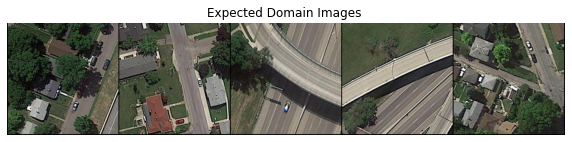

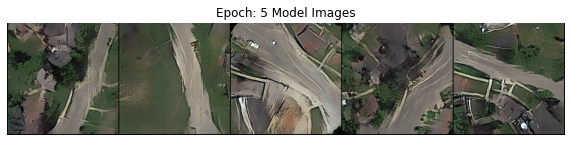

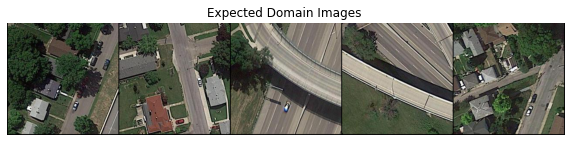

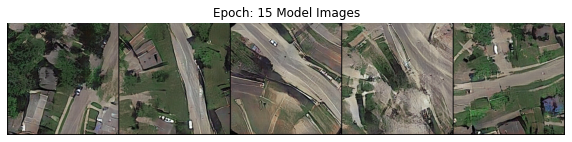

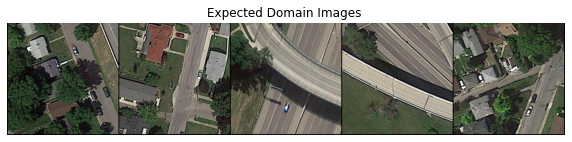

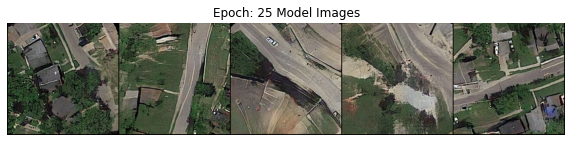

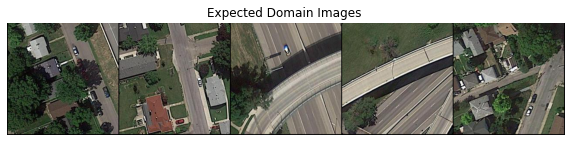

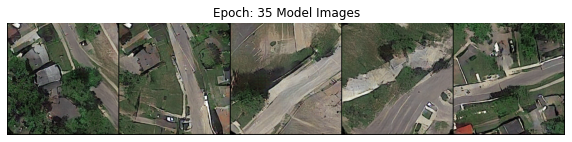

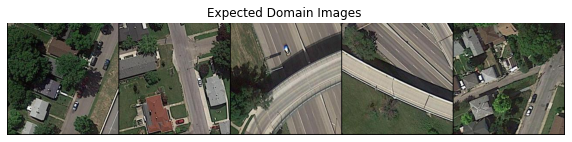

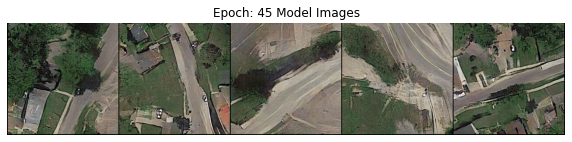

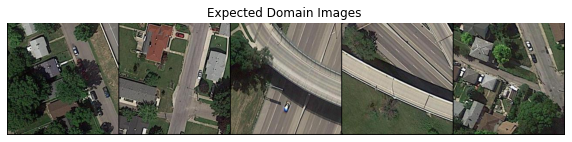

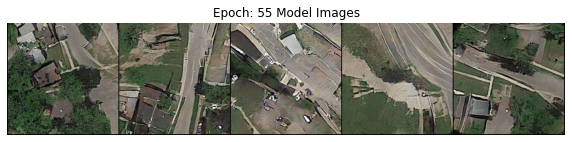

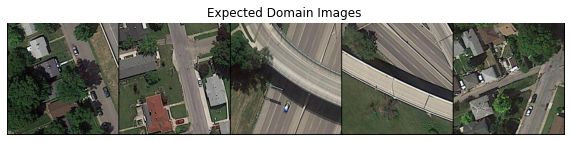

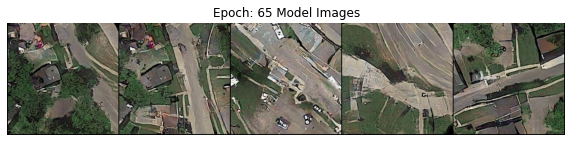

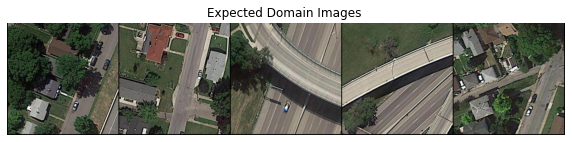

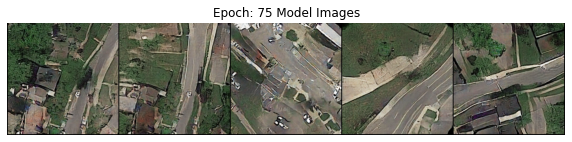

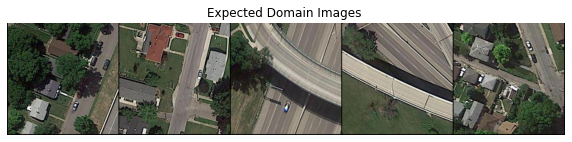

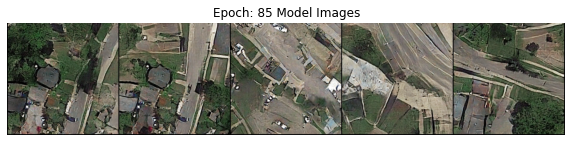

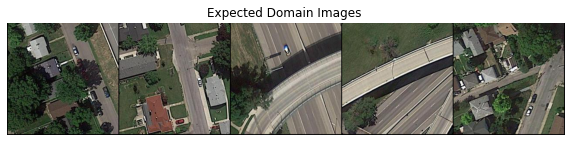

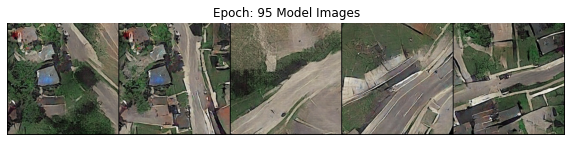

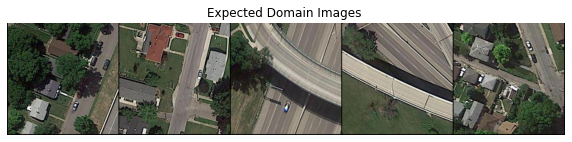

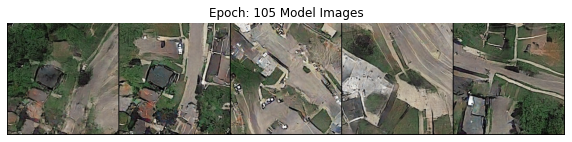

In [30]:
for i in range(5,110,10):
  display_images(train_eval_dl, i)

## Valiation Data Evaluation 

In [28]:
test_eval_ds = ImageFolder(testdata_path, transform=transforms.Compose([Transformations()]))
test_eval_dl = DataLoader(test_eval_ds, batch_size, shuffle=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


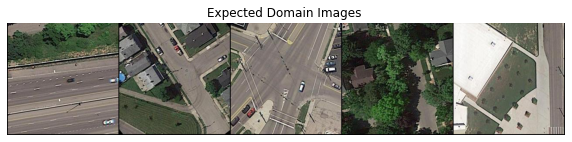

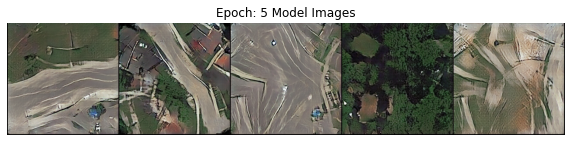

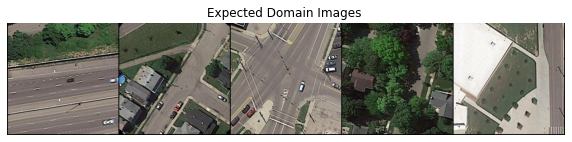

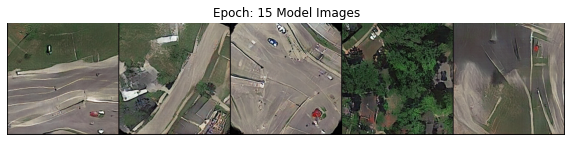

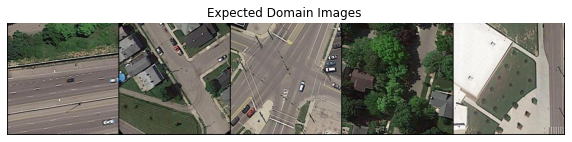

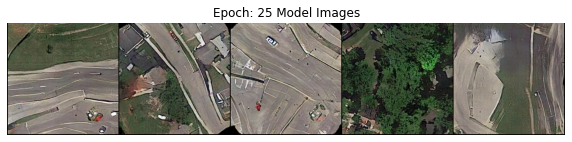

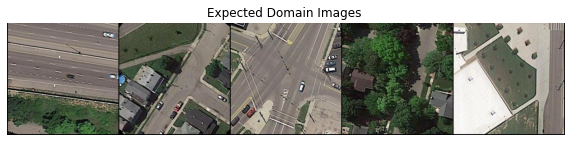

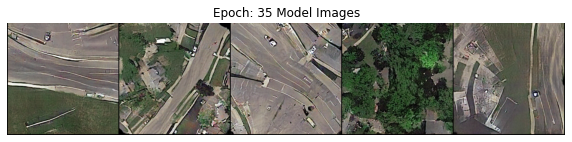

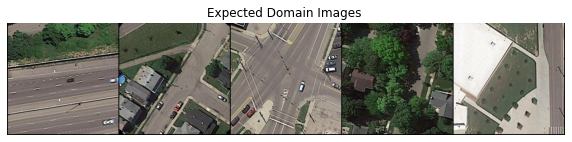

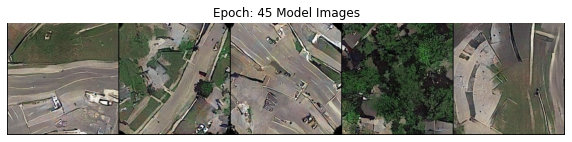

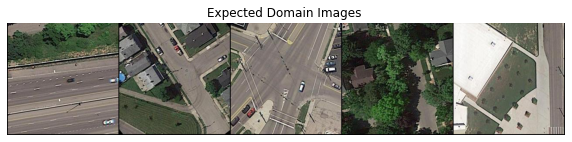

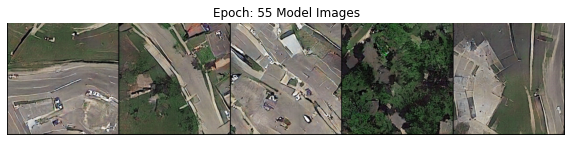

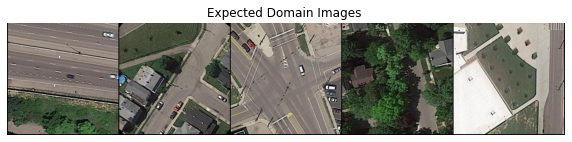

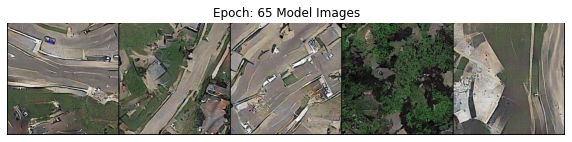

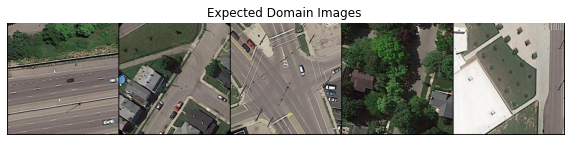

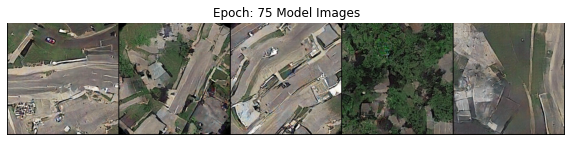

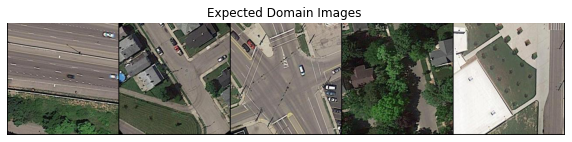

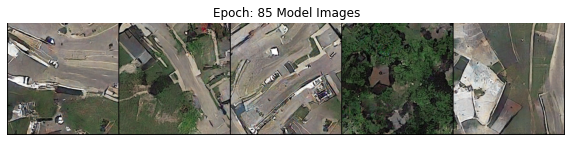

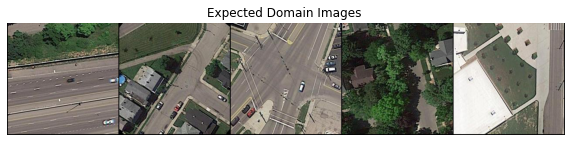

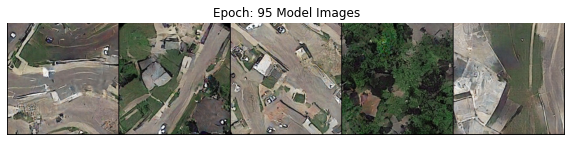

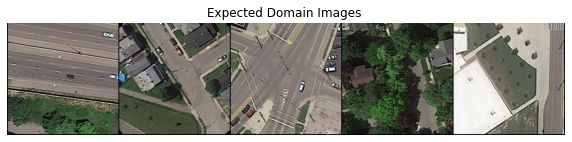

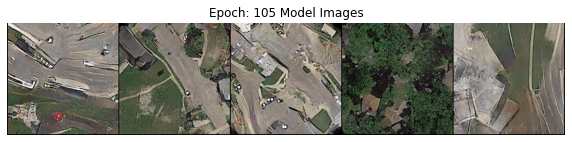

In [31]:
for i in range(5,110,10):
  display_images(test_eval_dl, i)